# Claim2Features

## Util

In [1]:
from utils.ml_utils import myHotEncode, myHotDecode, plot_confusion_matrix, text_to_wordEmbedding
from utils.text_utils import treat_text, pure_words, words_count

### Ignore Warning

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Pre-processing

In [63]:
%%time
import pandas as pd
import ast
import numpy as np


data_path = 'dataset.csv'
df = pd.read_csv(data_path)

columns = ['tag', 'text', 'attrs', 'level', 'brother_tag', 'brother_text', 'brother_attrs', 'url', 'site', 'label']
ignore_site = ['politifact', 'checkyourfact', 'theferret', 'theconversation']
words_context = []
brother_words_context = []

indexs = []
for i, d in enumerate(df.site):
    if d in ignore_site:
        indexs.append(i)
df = df.drop(indexs)
df = df.reset_index()

for tupla in df[columns].values:
    # In order to facilitate each instance is a dictionary 'dic'
    dic = {}
    for i, column in enumerate(columns):
        if column == 'text' or column == 'brother_text':
            dic[column] = str(tupla[i])
        else:
            dic[column] = tupla[i]
    
    # words_context attribute: the attrs is replace for words_context
    words_context_ = ''
    attrs = ast.literal_eval(dic['attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                words_context_ += pure_words(treat_text(str(a))) + ' '
    words_context.append(words_context_)
    
    # brother_words_context attribute: : the brother_attrs is replace for brother_words_context
    brother_words_context_ = ''
    attrs = ast.literal_eval(dic['brother_attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            brother_words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                brother_words_context_ += pure_words(treat_text(str(a))) + ' '
    brother_words_context.append(brother_words_context_)
    

del df['attrs']
df['words_context'] = words_context

del df['brother_attrs']
df['brother_words_context'] = brother_words_context

Wall time: 7.6 s


## Features

### Bag-of-words for context words in attrs

In [64]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


vocab_size = 2000
vec = CountVectorizer(max_features=vocab_size, stop_words=ENGLISH_STOP_WORDS, tokenizer=LemmaTokenizer())
vec.fit(df['words_context'])
words_context = vec.transform(list(df['words_context'])).toarray()
brother_words_context = vec.transform(list(df['brother_words_context'])).toarray()

Wall time: 36.4 s


### Word2Vec for text

#### Load word2vec model

In [65]:
%%time
import gensim
from gensim.models import KeyedVectors

w2v_patch = 'C:\word_embedding\GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore", binary=True)

Wall time: 48.1 s


#### word2vec text feature

In [66]:
%%time
df['text_w2v'] = text_to_wordEmbedding(list(df['text']), w2v)
df['brother_text_w2v'] = text_to_wordEmbedding(list(df['brother_text']), w2v)

Wall time: 37.7 s


### Text size

In [67]:
text_sizes = []
for size in df['text']:
    if type(size) == str:
        text_sizes.append([words_count(size)])
    else:
        text_sizes.append([0])
brother_text_sizes = []
for size in df['brother_text']:
    if type(size) == str:
        brother_text_sizes.append([words_count(size)])
    else:
        brother_text_sizes.append([0])

### Tag

In [68]:
tag2Idx = myHotEncode([df['tag']], 100)[1]
tag = myHotEncode([[x] for x in df['tag']], vocab2idx=tag2Idx)[0]
brother_tag = myHotEncode([[x] for x in df['brother_tag']], vocab2idx=tag2Idx)[0]

### Level

In [69]:
level = df['level']

## SVM

### Data preparation

In [70]:
%%time
last_levels = [-1]
last_labels = ['None']

last_tags = []
last_text_sizes = []
last_words_contexts = []
last_wordEmbedding = []
last_brother_tags = []
last_brother_text_sizes = []
last_brother_words_contexts = []
last_brother_wordEmbedding = []


def features(tag, text_size, words_context, wordEmbedding, level,
             brother_tag, brother_text_size, brother_words_context, brother_wordEmbedding,
             parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding):
    # Tag
    #return list(tag)
    
    # Level
    #return [level]
    
    # Words Contexts
    #return list(words_context)
    
    # Words Embedding
    return list(wordEmbedding)
    
    # Text sizes
    #return list(text_size)

    # Brothers tags
    #return list(brother_tag)
    
    # Brothers text sizes
    #return list(brother_text_size)
    
    # Brothers words contexts
    #return list(brother_words_context)
    
    # Parent tag
    #return list(parent_tag)
    
    # Parent text size
    #return list(parent_text_size)
    
    # Parent words contexts
    #return list(parent_words_context)
    
    # All
    #return list(tag) + list(text_size) + list(words_context) + [level] + list(brother_tag) + list(brother_text_size) + list(brother_words_context) + list(parent_tag) + list(parent_text_size) + list(parent_words_context)
    


X = []
X_ = []
y = []
group = []
last_group = None
last_url = 'NONE'

sizes = set()

for i in range(len(df)):
    if last_url != 'NONE' and df['url'][i] != last_url:
        if len(last_tags) > 0:
            # Parent
            if len(last_tags) > 1:
                parent_tag = last_tags[-2]
                parent_text_size = last_text_sizes[-2]
                parent_words_context = last_words_contexts[-2]
                parent_wordEmbedding = last_wordEmbedding[-2]
            else:
                print("here???")
                parent_tag = np.zeros(len(last_tags[-1]))
                parent_text_size = np.zeros(len(last_text_sizes[-1]))
                parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
                parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
            x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                         last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                         parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
            X.append(x)
            X_.append(list(last_tags[-1]).index(1)) # Debug control
            sizes.add(len(x))
            y_ = 'None'
            for y__ in last_labels:
                if y__ != 'None':
                    y_ = y__
            y.append(y_)
            group.append(last_group)
            last_labels = ['None']
            last_tags = []
            last_text_sizes = []
            last_words_contexts = []
            last_wordEmbedding = []
            last_levels = [-1]
            last_brother_tags = []
            last_brother_text_sizes = []
            last_brother_words_contexts = []
            last_brother_wordEmbedding = []
        last_url = df['url'][i]
        continue
        
    last_url = df['url'][i]
    level_ = df['level'][i]
    
    if level_ > last_levels[-1]:
        last_tags.append(tag[i])
        last_text_sizes.append(text_sizes[i])
        last_words_contexts.append(words_context[i])
        last_wordEmbedding.append(df['text_w2v'][i])
        last_levels.append(level_)
        last_brother_tags.append(brother_tag[i])
        last_brother_text_sizes.append(brother_text_sizes[i])
        last_brother_words_contexts.append(brother_words_context[i])
        last_brother_wordEmbedding.append(df['brother_text_w2v'][i])
        last_labels.append(df['label'][i])
            
    else:
        if len(last_tags) > 0:
            # Parent
            if len(last_tags) > 1:
                parent_tag = last_tags[-2]
                parent_text_size = last_text_sizes[-2]
                parent_words_context = last_words_contexts[-2]
                parent_wordEmbedding = last_wordEmbedding[-2]
            else:
                print("here???")
                parent_tag = np.zeros(len(last_tags[-1]))
                parent_text_size = np.zeros(len(last_text_sizes[-1]))
                parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
                parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
            x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                         last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                         parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
            X.append(x)
            X_.append(list(last_tags[-1]).index(1))  # Debug control
            sizes.add(len(x))
            y_ = 'None'
            for y__ in last_labels:
                if y__ != 'None':
                    y_ = y__
            y.append(y_)
            group.append(last_group)
            # Remove last data used
            last_labels = last_labels[:level_-1]
            last_tags = last_tags[:level_-1]
            last_text_sizes = last_text_sizes[:level_-1]
            last_words_contexts = last_words_contexts[:level_-1]
            last_wordEmbedding = last_wordEmbedding[:level_-1]
            last_levels = last_levels[:level_-1]
            last_brother_tags = last_brother_tags[:level_-1]
            last_brother_text_sizes = last_brother_text_sizes[:level_-1]
            last_brother_words_contexts = last_brother_words_contexts[:level_-1]
            last_brother_wordEmbedding = last_brother_wordEmbedding[:level_-1]

            last_tags.append(tag[i])
            last_text_sizes.append(text_sizes[i])
            last_words_contexts.append(words_context[i])
            last_wordEmbedding.append(df['text_w2v'][i])
            last_levels.append(level_)
            last_brother_tags.append(brother_tag[i])
            last_brother_text_sizes.append(brother_text_sizes[i])
            last_brother_words_contexts.append(brother_words_context[i])
            last_brother_wordEmbedding.append(df['brother_text_w2v'][i])
            last_labels.append(df['label'][i])
    last_group = df['site'][i]

if len(last_tags) > 0:
    # Parent
    if len(last_tags) > 1:
        parent_tag = last_tags[-2]
        parent_text_size = last_text_sizes[-2]
        parent_words_context = last_words_contexts[-2]
        parent_wordEmbedding = last_wordEmbedding[-2]
    else:
        print("here???")
        parent_tag = np.zeros(len(last_tags[-1]))
        parent_text_size = np.zeros(len(last_text_sizes[-1]))
        parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
        parent_wordEmbedding = np.zeros(len(last_wordEmbedding[-1]))
    x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_wordEmbedding[-1], last_levels[-1], 
                 last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1], last_brother_wordEmbedding[-1],
                 parent_tag, parent_text_size, parent_words_context, parent_wordEmbedding)
    X.append(x)
    X_.append(list(last_tags[-1]).index(1)) # Debug control
    sizes.add(len(x))
    y_ = 'None'
    for y__ in last_labels:
        if y__ != 'None':
            y_ = y__
    y.append(y_)
    group.append(last_group)
    
X = np.array(X)
y = np.array(y)
group = np.array(group)

### Train and Evaluation

Using TensorFlow backend.


Train Groups (URLs) {1, 2, 3, 4, 5, 6}
Test Groups (URLs) {0}


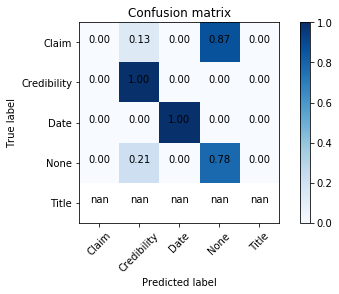

Acc: 77.95 %
Precision: 40.15 %
Recall: 55.60 %
F1: 37.89 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6}
Test Groups (URLs) {1}


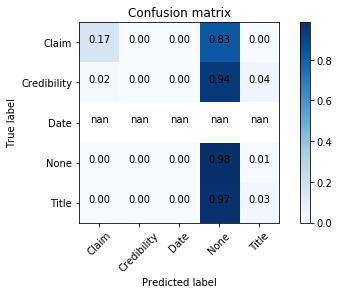

Acc: 95.77 %
Precision: 20.74 %
Recall: 23.54 %
F1: 21.07 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6}
Test Groups (URLs) {2}


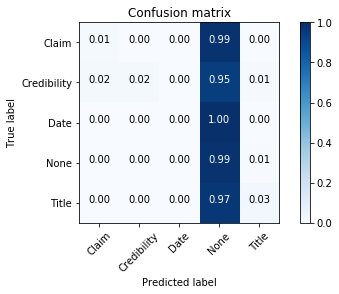

Acc: 94.29 %
Precision: 25.37 %
Recall: 21.06 %
F1: 21.16 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6}
Test Groups (URLs) {3}


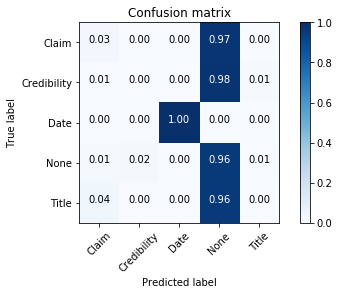

Acc: 92.62 %
Precision: 21.53 %
Recall: 39.73 %
F1: 23.22 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6}
Test Groups (URLs) {4}


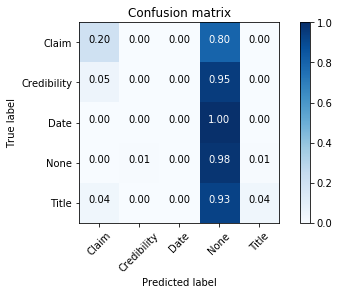

Acc: 96.67 %
Precision: 21.25 %
Recall: 24.30 %
F1: 21.85 %

Train Groups (URLs) {0, 1, 2, 3, 4, 6}
Test Groups (URLs) {5}


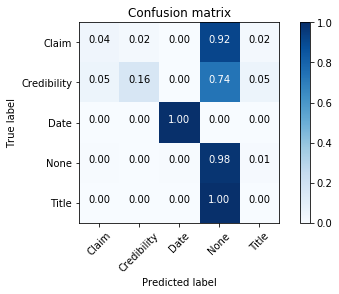

Acc: 96.04 %
Precision: 38.63 %
Recall: 43.57 %
F1: 39.12 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5}
Test Groups (URLs) {6}


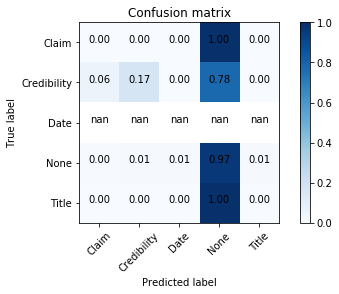

Acc: 96.30 %
Precision: 21.45 %
Recall: 22.68 %
F1: 21.73 %

Acc 92.81 % (+/- 6.20 %)
Precision 27.02 % (+/- 7.96 %)
Recall 32.93 % (+/- 12.43 %)
F1 26.58 % (+/- 7.58 %)


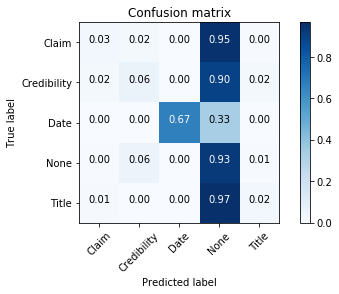

Wall time: 11min 39s


In [71]:
%%time
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

# Aux print
_, site2Idx = myHotEncode([[u] for u in group])

gp = GroupKFold(n_splits=7)
for train_indexs, test_indexs in gp.split(X, groups=group):
    
    X_train = X[train_indexs]
    y_train = y[train_indexs]
    
    X_test = X[test_indexs]
    y_test = y[test_indexs]
    
    groups_train = group[train_indexs]
    groups_test = group[test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(site2Idx[g])
    for g in groups_test:
        test_g.add(site2Idx[g])
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    result = svm.predict(X_test)

    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    cm_ = confusion_matrix(result, y_test)
    plot_confusion_matrix(cm_, svm.classes_, normalize=True) 
    confusion.append(cm_)
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

nc = []
for c in confusion:
    d = len(svm.classes_) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, svm.classes_, normalize=True)

## Debug and Check data

In [ ]:
for x_, y_, g_ in zip(X,y,group):
    if y_ == 'Credibility' and g_ != 'checkyourfact':
        print(x_)

In [ ]:
svm.predict([[x__] for x__ in range(0,350)])

In [ ]:
site2Idx

In [ ]:
len(X)

In [ ]:
%%time
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

X_train = X[:20000]
y_train = y[:20000]
    
X_test = X[20000:]
y_test = y[20000:]

svm = RandomForestClassifier()
svm.fit(X_train, y_train)
result = svm.predict(X_test)

acc = accuracy_score(result, y_test)
accuracy.append(acc)
p = precision_score(result, y_test, average="macro")
precision.append(p)
r = recall_score(result, y_test, average="macro")
recall.append(r)
f = f1_score(result, y_test, average="macro")
f1.append(f)
confusion.append(confusion_matrix(result, y_test))
    
print("%s: %.2f %%" % ('Acc', acc*100))
print("%s: %.2f %%" % ('Precision', p*100))
print("%s: %.2f %%" % ('Recall', r*100))
print("%s: %.2f %%" % ('F1', f*100))
print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

nc = []
for c in confusion:
    d = len(svm.classes_) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, svm.classes_, normalize=True) 